In [5]:

%pip install seaborn
%pip install pgmpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, norm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.feature_selection import SelectKBest, f_classif

# Bayesian Network libraries - using correct class name
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
df = pd.read_csv(r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata (1).csv")

In [21]:
# --- Data cleaning & feature engineering
# This cell performs: column cleanup, date parsing, deduplication, missing value handling,
# outlier capping, new feature creation, and saving a cleaned CSV.

# Remove any unnamed index-like column (e.g., 'Unnamed: 0') that came from CSV


# Rename columns for consistency
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df = df.rename(columns={
    'AvgTemperture': 'AvgTemperature',
    'AverageDew(point via humidity)': 'AvgDew',
    'Solar(PV)': 'Solar_PV'
})

# Parse Date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Sort and drop duplicate dates (keep first measurement per date)
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop_duplicates(subset=['Date'], keep='first')

# Quick diagnostics
print('Shape after dedup:', df.shape)
print('\nMissing values per column:\n', df.isnull().sum())

# Impute numeric missing values with median
num_cols = df.select_dtypes(include='number').columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Cap outliers per column using IQR method
def cap_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return col.clip(lower, upper)

df[num_cols] = df[num_cols].apply(cap_outliers)

# Feature engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5

df['temp_dew_diff'] = df['AvgTemperature'] - df['AvgDew']
df['solar_log'] = np.log1p(df['Solar_PV'])

df['temp_rolling_3'] = df['AvgTemperature'].rolling(window=3, min_periods=1).mean()
df['temp_lag_1'] = df['AvgTemperature'].shift(1).fillna(method='bfill')

# --- Classification / binning additions ---
# Create pressure categories (low/medium/high) using tertiles (qcut);
# fallback to cut if qcut fails due to insufficient unique values.
try:
    df['pressure_cat'] = pd.qcut(df['Pressure'], q=3, labels=['low','medium','high'])
except ValueError:
    try:
        df['pressure_cat'] = pd.cut(df['Pressure'], bins=3, labels=['low','medium','high'])
    except Exception:
        df['pressure_cat'] = 'normal'

# Create Solar_PV categories and a binary high-output flag
try:
    df['solar_bin'] = pd.qcut(df['Solar_PV'], q=3, labels=['low','medium','high'])
except ValueError:
    df['solar_bin'] = pd.cut(df['Solar_PV'], bins=3, labels=['low','medium','high'])

# Binary flag for high solar output (top 25%)
df['is_solar_high'] = df['Solar_PV'] > df['Solar_PV'].quantile(0.75)

# Save cleaned dataset
out_path = r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv"
df.to_csv(out_path, index=False)
print('\nCleaned data saved to:', out_path)

# Show the cleaned head and a brief summary
print('\nCleaned data sample:')
df.head(10)

Shape after dedup: (370, 23)

Missing values per column:
 Date                    0
AvgTemperature          0
AvgDew                  0
Humidity                0
Wind                    0
Pressure                0
Solar_PV                0
year                    0
month                   0
day                     0
dayofweek               0
is_weekend              0
temp_dew_diff           0
solar_log               0
temp_rolling_3          0
temp_lag_1              0
pressure_cat            0
solar_bin               0
is_solar_high           0
temp_wind_pressure      0
temp_wind_pressure_z    0
is_high_solar           0
Season                  0
dtype: int64

Cleaned data saved to: C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv

Cleaned data sample:


,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,...,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high,temp_wind_pressure,temp_wind_pressure_z,is_high_solar,Season
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,...,3.472428,80.000000,80.0,medium,high,False,29.863013,0.093207,1,Spring
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,...,3.556661,79.850000,80.0,medium,high,True,28.113355,-0.094823,1,Spring
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,...,3.560681,78.966667,79.7,medium,high,True,28.553424,-0.047530,1,Spring
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,...,3.479463,76.666667,77.2,medium,high,False,22.530821,-0.694761,1,Spring
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,...,3.484514,78.633333,73.1,medium,high,False,22.279451,-0.721775,1,Spring
5,2021-04-06,81.0,37.3,21.0,12.3,29.2,30.525429,2021,4,6,...,3.450794,79.900000,85.6,medium,high,False,34.119862,0.550678,1,Spring
6,2021-04-07,85.9,37.9,18.5,14.3,29.2,35.386857,2021,4,7,...,3.594208,84.166667,81.0,medium,high,True,42.067464,1.404782,1,Spring
7,2021-04-08,77.6,31.9,19.6,16.6,29.2,33.410286,2021,4,8,...,3.538356,81.500000,85.9,medium,high,True,44.115067,1.624832,1,Spring
8,2021-04-09,72.7,32.1,23.4,11.7,29.2,36.437143,2021,4,9,...,3.622663,78.733333,77.6,medium,high,True,29.129794,0.014410,1,Spring
9,2021-04-10,74.4,31.9,22.2,12.7,29.3,34.797429,2021,4,10,...,3.577876,74.900000,72.7,medium,high,True,32.248463,0.349564,1,Spring


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370 entries, 0 to 396
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      370 non-null    int64         
 1   Date            370 non-null    datetime64[ns]
 2   AvgTemperature  370 non-null    float64       
 3   AvgDew          370 non-null    float64       
 4   Humidity        370 non-null    float64       
 5   Wind            370 non-null    float64       
 6   Pressure        370 non-null    float64       
 7   Solar_PV        370 non-null    float64       
 8   year            370 non-null    int32         
 9   month           370 non-null    int32         
 10  day             370 non-null    int32         
 11  dayofweek       370 non-null    int32         
 12  is_weekend      370 non-null    bool          
 13  temp_dew_diff   370 non-null    float64       
 14  solar_log       370 non-null    float64       
 15  temp_rollin

In [9]:
df.describe()

,Unnamed: 0,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,dayofweek,temp_dew_diff,solar_log,temp_rolling_3,temp_lag_1
count,370.000000,370,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,225.170270,2021-10-13 09:36:00,81.405676,37.460811,23.753784,10.314865,29.190135,24.800943,2021.297297,6.354054,15.883784,3.005405,43.944865,3.203293,81.374459,81.372973
min,4.000000,2021-04-01 00:00:00,51.100000,15.300000,7.400000,4.400000,28.900000,8.581429,2021.000000,1.000000,1.000000,0.000000,19.900000,2.259827,51.833333,51.100000
25%,127.250000,2021-07-07 06:00:00,69.725000,30.400000,16.325000,8.500000,29.100000,18.038214,2021.000000,4.000000,8.000000,1.000000,34.925000,2.946448,68.916667,69.725000
50%,229.500000,2021-10-09 12:00:00,84.250000,38.200000,21.200000,10.300000,29.200000,24.368714,2021.000000,6.000000,16.000000,3.000000,45.800000,3.233515,83.566667,84.100000
75%,322.750000,2022-01-22 12:00:00,93.900000,44.300000,29.600000,12.175000,29.300000,32.216500,2022.000000,9.000000,23.000000,5.000000,52.900000,3.503047,93.791667,93.900000
max,421.000000,2022-04-29 00:00:00,102.700000,63.900000,47.700000,17.100000,29.600000,40.038857,2022.000000,12.000000,31.000000,6.000000,73.000000,3.714519,101.000000,102.700000
std,116.088092,NaN,13.961259,8.749325,9.641380,2.454501,0.141962,7.598311,0.457687,3.321368,8.789931,1.976823,11.934301,0.315000,13.701923,13.950308


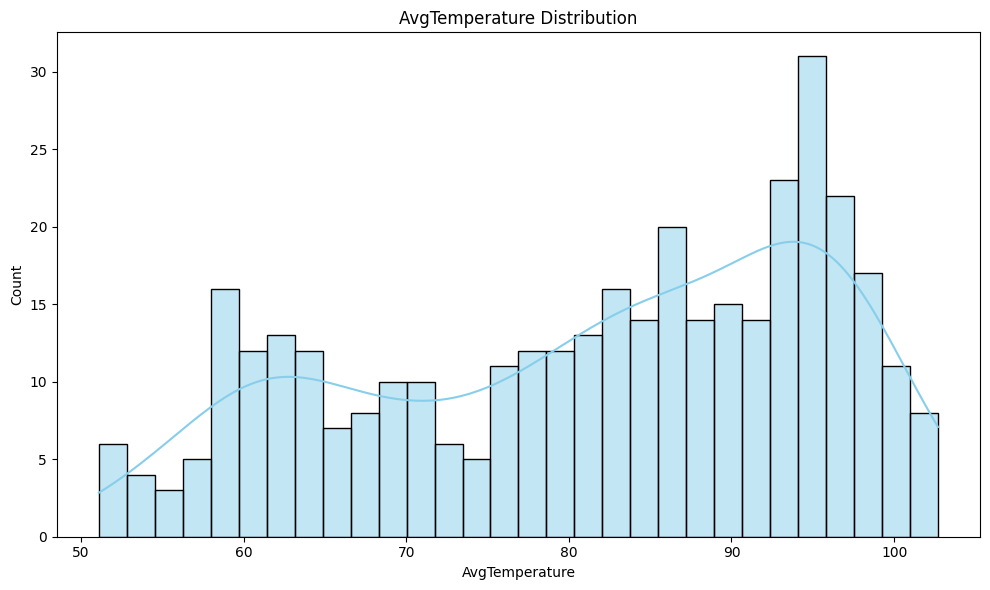

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df['AvgTemperature'], bins=30, kde=True, color='skyblue')
plt.title('AvgTemperature Distribution')
plt.xlabel('AvgTemperature')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Added features: temp_wind_pressure, temp_wind_pressure_z


,count,mean,std,min,25%,50%,75%,max
temp_wind_pressure,370.0,28.988240,9.294436,8.903051,21.868269,28.148773,35.780089,56.647818
temp_wind_pressure_z,370.0,-0.000802,0.998845,-2.159296,-0.765964,-0.091017,0.729097,2.971688


Mutual information (temp_wind_pressure vs pressure_cat): 0.1259
Correlation with Pressure:  -0.45312274077911724
Correlation with Solar_PV:  0.12376590777528454


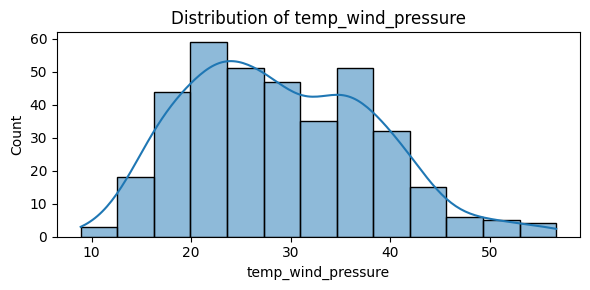

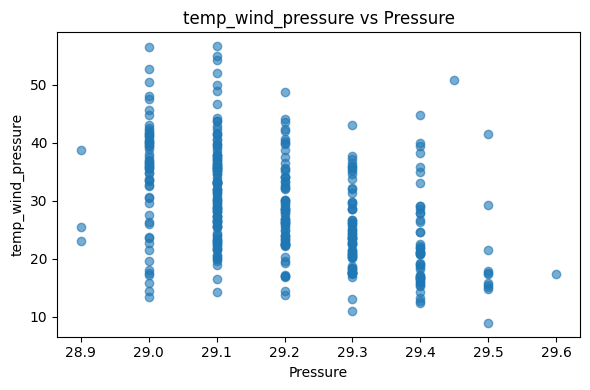


Updated cleaned data saved to: C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv


In [11]:
# --- Composite feature: temperature x wind / pressure
# Adds `temp_wind_pressure` and `temp_wind_pressure_z` to the dataframe,
# caps outliers, prints diagnostics, plots, and updates the cleaned CSV.

eps = 1e-6
if 'AvgTemperature' in df.columns and 'Wind' in df.columns and 'Pressure' in df.columns:
    df['temp_wind_pressure'] = (df['AvgTemperature'] * df['Wind']) / (df['Pressure'] + eps)
    df['temp_wind_pressure_z'] = (df['temp_wind_pressure'] - df['temp_wind_pressure'].mean()) / (df['temp_wind_pressure'].std(ddof=0))

    # Apply existing outlier capping helper
    df['temp_wind_pressure'] = cap_outliers(df['temp_wind_pressure'])
    df['temp_wind_pressure_z'] = cap_outliers(df['temp_wind_pressure_z'])

    print('Added features: temp_wind_pressure, temp_wind_pressure_z')
    display(df[['temp_wind_pressure','temp_wind_pressure_z']].describe().T)

    # Mutual information with pressure_cat if present
    if 'pressure_cat' in df.columns:
        from sklearn.feature_selection import mutual_info_classif
        lbls = pd.factorize(df['pressure_cat'])[0]
        mi_new = mutual_info_classif(df[['temp_wind_pressure']].fillna(0), lbls, random_state=42)
        print(f"Mutual information (temp_wind_pressure vs pressure_cat): {mi_new[0]:.4f}")

    # Quick correlations
    print('Correlation with Pressure: ', df['temp_wind_pressure'].corr(df['Pressure']))
    if 'Solar_PV' in df.columns:
        print('Correlation with Solar_PV: ', df['temp_wind_pressure'].corr(df['Solar_PV']))

    # Distribution plot
    plt.figure(figsize=(6,3))
    sns.histplot(df['temp_wind_pressure'].dropna(), kde=True)
    plt.title('Distribution of temp_wind_pressure')
    plt.tight_layout()
    plt.show()

    # Scatter vs Pressure
    plt.figure(figsize=(6,4))
    plt.scatter(df['Pressure'], df['temp_wind_pressure'], alpha=0.6)
    plt.xlabel('Pressure'); plt.ylabel('temp_wind_pressure')
    plt.title('temp_wind_pressure vs Pressure')
    plt.tight_layout()
    plt.show()

    # Save updated cleaned data
    out_path = r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv"
    df.to_csv(out_path, index=False)
    print('\nUpdated cleaned data saved to:', out_path)
else:
    raise KeyError('Required columns (AvgTemperature, Wind, Pressure) not found in df')

Optimal K found: 5
--- KNN Performance (k=5) ---
1. Accuracy:       0.6351 (63.5%)
2. Error Rate:     0.3649 (36.5%)
3. Precision:      0.6944
4. Recall:         0.6098
5. F-measure (F1): 0.6494
6. ROC Area (AUC): 0.6330
------------------------------
Confusion Matrix:
[[22 11]
 [16 25]]


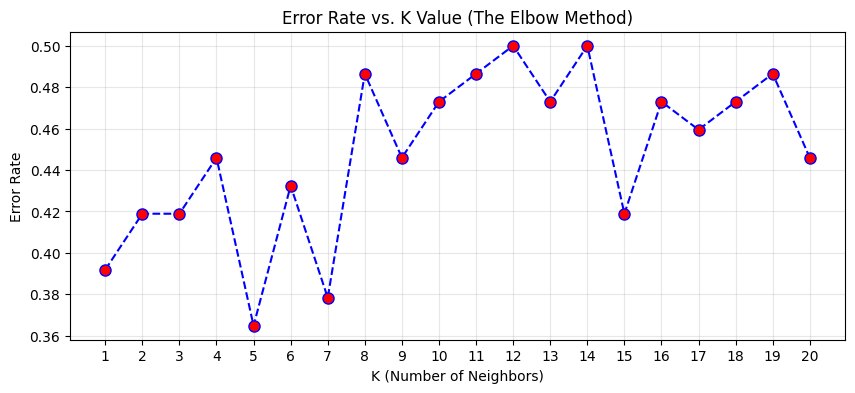

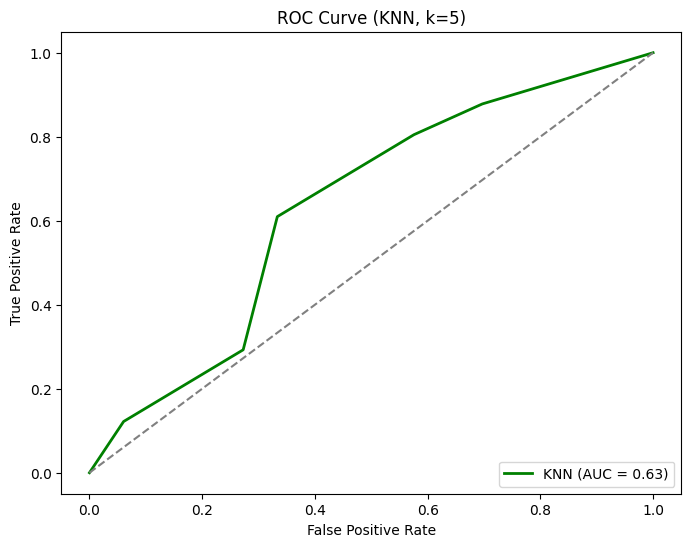

<Figure size 600x500 with 0 Axes>

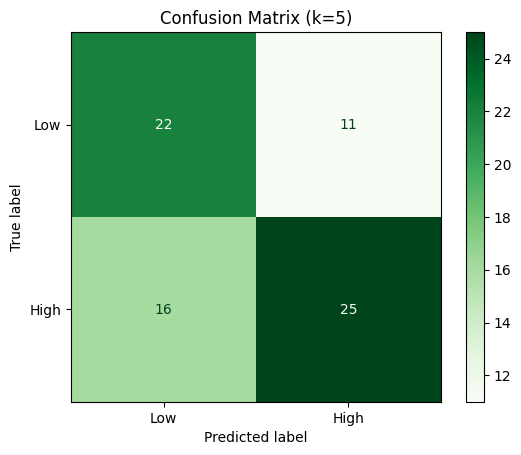

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_curve, auc, 
                             ConfusionMatrixDisplay)

# --- 1. Prepare Data & Features ---
# Target: 1 if Solar is "High", 0 if "Low"
median_solar = df['Solar_PV'].median()
df['is_high_solar'] = (df['Solar_PV'] > median_solar).astype(int)

# Use your advanced feature list
# Create interaction features if they don't already exist
if 'temp_wind_pressure' not in df.columns:
    df['temp_wind_pressure'] = df['AvgTemperature'] * df['Wind'] * df['Pressure']

if 'temp_wind_pressure_z' not in df.columns:
    t = df['temp_wind_pressure']
    # z-score with safe fallback to avoid division by zero
    denom = t.std(ddof=0)
    if denom == 0 or np.isnan(denom):
        df['temp_wind_pressure_z'] = 0.0
    else:
        df['temp_wind_pressure_z'] = (t - t.mean()) / denom

features = [
    'AvgTemperature',
    'Humidity',
    'Wind',
    'Pressure',
    'temp_wind_pressure',
    'temp_wind_pressure_z'
]

X = df[features]
y = df['is_high_solar']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Scaling (CRITICAL FOR KNN) ---
# We must scale features so they have Mean=0 and Std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. Find the Best 'K' (Elbow Method) ---
error_rates = []
k_range = range(1, 21) # Test K from 1 to 20

for k in k_range:
    knn_i = KNeighborsClassifier(n_neighbors=k)
    knn_i.fit(X_train_scaled, y_train)
    pred_i = knn_i.predict(X_test_scaled)
    error_rates.append(np.mean(pred_i != y_test))

# Pick the K with the lowest error
best_k = k_range[np.argmin(error_rates)]
print(f"Optimal K found: {best_k}")

# --- 4. Train Final Model with Best K ---
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

# --- 5. Calculate All Metrics ---
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# --- 6. Print Detailed Report ---
print(f"--- KNN Performance (k={best_k}) ---")
print(f"1. Accuracy:       {accuracy:.4f} ({(accuracy*100):.1f}%)")
print(f"2. Error Rate:     {error_rate:.4f} ({(error_rate*100):.1f}%)")
print(f"3. Precision:      {precision:.4f}")
print(f"4. Recall:         {recall:.4f}")
print(f"5. F-measure (F1): {f_measure:.4f}")
print(f"6. ROC Area (AUC): {roc_auc:.4f}")
print("-" * 30)
print(f"Confusion Matrix:\n{cm}")

# --- 7. Visualizations ---

# Visual A: The Elbow Plot (How we found K)
plt.figure(figsize=(10, 4))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value (The Elbow Method)')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.xticks(k_range)
plt.grid(alpha=0.3)
plt.show()

# Visual B: ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'ROC Curve (KNN, k={best_k})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Visual C: Confusion Matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', display_labels=['Low', 'High'])
plt.title(f'Confusion Matrix (k={best_k})')
plt.show()

Added features: temp_wind_pressure, temp_wind_pressure_z


,count,mean,std,min,25%,50%,75%,max
temp_wind_pressure,370.0,28.988240,9.294436,8.903051,21.868269,28.148773,35.780089,56.647818
temp_wind_pressure_z,370.0,-0.000802,0.998845,-2.159296,-0.765964,-0.091017,0.729097,2.971688


Mutual information (temp_wind_pressure vs pressure_cat): 0.1259
Correlation with Pressure:  -0.45312274077911724
Correlation with Solar_PV:  0.12376590777528454


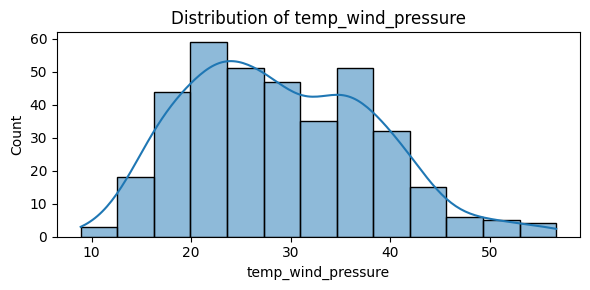

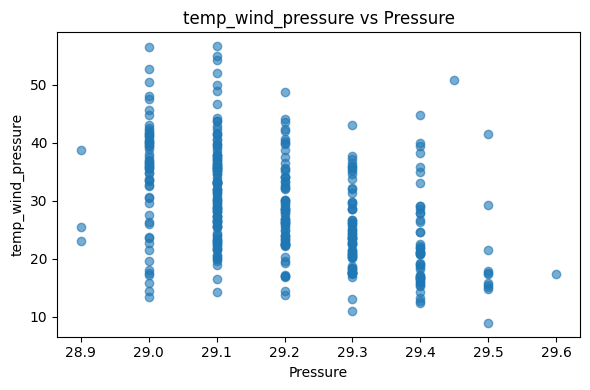


Updated cleaned data saved to: C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv


In [13]:
# --- New composite feature: temperature x wind / pressure
# Adds `temp_wind_pressure` and a z-scored variant `temp_wind_pressure_z` to the dataframe,
# caps outliers, shows basic stats/plots, and updates the cleaned CSV.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

eps = 1e-6
if 'AvgTemperature' in df.columns and 'Wind' in df.columns and 'Pressure' in df.columns:
    df['temp_wind_pressure'] = (df['AvgTemperature'] * df['Wind']) / (df['Pressure'] + eps)
    df['temp_wind_pressure_z'] = (df['temp_wind_pressure'] - df['temp_wind_pressure'].mean()) / (df['temp_wind_pressure'].std(ddof=0))

    # Cap outliers using the helper already defined earlier
    df['temp_wind_pressure'] = cap_outliers(df['temp_wind_pressure'])
    df['temp_wind_pressure_z'] = cap_outliers(df['temp_wind_pressure_z'])

    print('Added features: temp_wind_pressure, temp_wind_pressure_z')
    display(df[['temp_wind_pressure','temp_wind_pressure_z']].describe().T)

    # Mutual information with pressure_cat if available
    if 'pressure_cat' in df.columns:
        from sklearn.feature_selection import mutual_info_classif
        lbls = pd.factorize(df['pressure_cat'])[0]
        mi_new = mutual_info_classif(df[['temp_wind_pressure']].fillna(0), lbls, random_state=42)
        print(f"Mutual information (temp_wind_pressure vs pressure_cat): {mi_new[0]:.4f}")

    # Quick correlations
    print('Correlation with Pressure: ', df['temp_wind_pressure'].corr(df['Pressure']))
    print('Correlation with Solar_PV: ', df['temp_wind_pressure'].corr(df['Solar_PV']))

    # Distribution plot
    plt.figure(figsize=(6,3))
    sns.histplot(df['temp_wind_pressure'].dropna(), kde=True)
    plt.title('Distribution of temp_wind_pressure')
    plt.tight_layout()
    plt.show()

    # Scatter vs Pressure
    plt.figure(figsize=(6,4))
    plt.scatter(df['Pressure'], df['temp_wind_pressure'], alpha=0.6)
    plt.xlabel('Pressure'); plt.ylabel('temp_wind_pressure')
    plt.title('temp_wind_pressure vs Pressure')
    plt.tight_layout()
    plt.show()

    # Save updated cleaned data
    out_path = r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv"
    df.to_csv(out_path, index=False)
    print('\nUpdated cleaned data saved to:', out_path)
else:
    raise KeyError('Required columns (AvgTemperature, Wind, Pressure) not found in df')

Note: you may need to restart the kernel to use updated packages.
Z-statistic: 1.397, P-value: 0.162



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


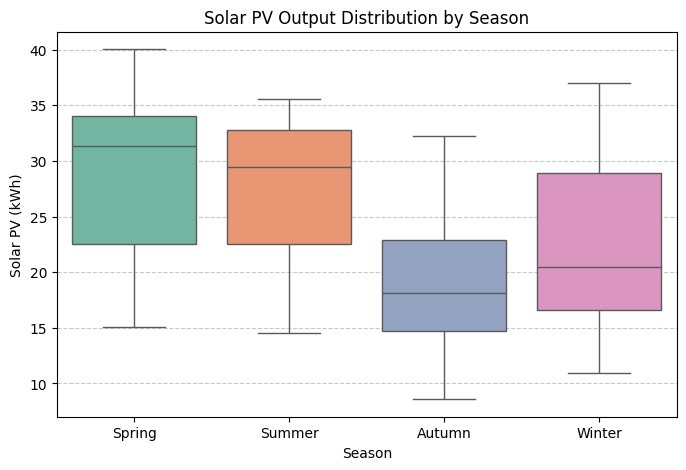

In [14]:
# Install statsmodels if missing (silent install)
%pip install -q statsmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest

# 1. Define Seasons
def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Autumn'
    else: return 'Winter'

if 'Season' not in df.columns:
    df['Season'] = df['month'].apply(get_season)

# 2. Statistical Test
spring_solar = df[df['Season'] == 'Spring']['Solar_PV']
summer_solar = df[df['Season'] == 'Summer']['Solar_PV']
z_stat, p_value = ztest(spring_solar, summer_solar, value=0)

print(f"Z-statistic: {z_stat:.3f}, P-value: {p_value:.3f}")

# --- VISUALIZATION ---
plt.figure(figsize=(8, 5))
# Use a specific order to keep Spring and Summer next to each other
sns.boxplot(x='Season', y='Solar_PV', data=df, order=['Spring', 'Summer', 'Autumn', 'Winter'], palette='Set2')
plt.title('Solar PV Output Distribution by Season')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Solar PV (kWh)')
plt.show()

F-statistic: 240.886, P-value: 0.000


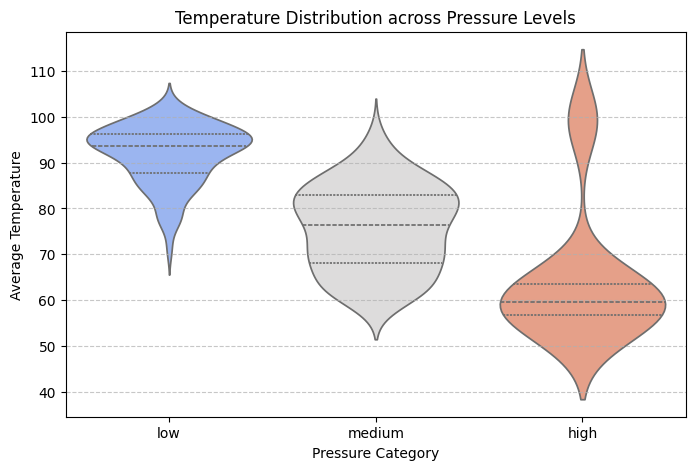

In [15]:
from scipy import stats

# 1. ANOVA Analysis
groups = [df[df['pressure_cat'] == c]['AvgTemperature'] for c in df['pressure_cat'].unique()]
f_stat, p_val = stats.f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}, P-value: {p_val:.3f}")

# --- VISUALIZATION ---
plt.figure(figsize=(8, 5))
sns.violinplot(x='pressure_cat', y='AvgTemperature', data=df, palette='coolwarm', inner='quartile')
plt.title('Temperature Distribution across Pressure Levels')
plt.xlabel('Pressure Category')
plt.ylabel('Average Temperature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
df.head()

,Unnamed: 0,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,...,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high,temp_wind_pressure,temp_wind_pressure_z,is_high_solar,Season
0,392,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,...,3.472428,80.000000,80.0,medium,high,False,29.863013,0.093207,1,Spring
1,393,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,...,3.556661,79.850000,80.0,medium,high,True,28.113355,-0.094823,1,Spring
2,394,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,...,3.560681,78.966667,79.7,medium,high,True,28.553424,-0.047530,1,Spring
3,395,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,...,3.479463,76.666667,77.2,medium,high,False,22.530821,-0.694761,1,Spring
4,396,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,...,3.484514,78.633333,73.1,medium,high,False,22.279451,-0.721775,1,Spring


In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ztest

# 1. Prepare Data
# We define "High Pressure" as anything above the median
pressure_median = df['Pressure'].median()

# Group 1: Solar Output on High Pressure days
high_pressure_solar = df[df['Pressure'] >= pressure_median]['Solar_PV']

# Group 2: Solar Output on Low Pressure days
low_pressure_solar = df[df['Pressure'] < pressure_median]['Solar_PV']

# 2. Perform Two-Sample Z-Test
# Null Hypothesis (H0): The mean Solar Output is the same for both groups.
# Alternate Hypothesis (H1): The mean Solar Output is different.
z_stat, p_value = ztest(high_pressure_solar, low_pressure_solar)

# 3. Print Results
print("--- Z-Test Results: Pressure vs. Solar PV ---")
print(f"High Pressure Mean Solar: {high_pressure_solar.mean():.2f} kWh")
print(f"Low Pressure Mean Solar:  {low_pressure_solar.mean():.2f} kWh")
print("-" * 30)
print(f"Z-Score: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# 4. Interpretation
if p_value < 0.05:
    print("Conclusion: SIGNIFICANT. Pressure levels affect Solar Output.")
else:
    print("Conclusion: NOT SIGNIFICANT. Solar Output is similar regardless of Pressure.")

--- Z-Test Results: Pressure vs. Solar PV ---
High Pressure Mean Solar: 25.24 kWh
Low Pressure Mean Solar:  24.30 kWh
------------------------------
Z-Score: 1.1953
P-Value: 0.2320
Conclusion: NOT SIGNIFICANT. Solar Output is similar regardless of Pressure.


--- ANOVA Results ---
1. Temperature Effect on Solar PV:
   F-Score: 0.0188
   P-Value: 9.8141e-01
   -> Result: NOT Significant.

2. Pressure Effect on Solar PV:
   F-Score: 1.1104
   P-Value: 3.3052e-01
   -> Result: NOT Significant.


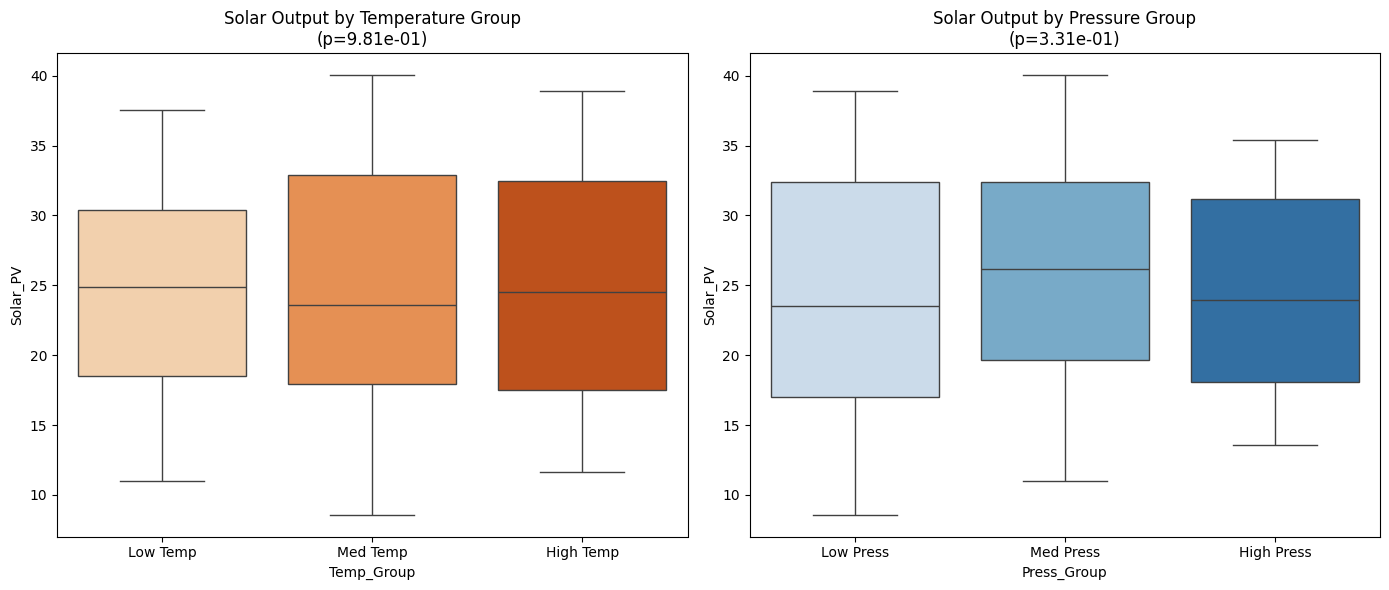

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Prepare Data: Binning Continuous Variables
# We split Temperature and Pressure into 3 Groups: "Low", "Medium", "High"
df['Temp_Group'] = pd.qcut(df['AvgTemperature'], q=3, labels=['Low Temp', 'Med Temp', 'High Temp'])
df['Press_Group'] = pd.qcut(df['Pressure'], q=3, labels=['Low Press', 'Med Press', 'High Press'])

# 2. Perform ANOVA: AvgTemperature vs Solar_PV
# We collect the Solar values for each Temperature group
solar_low_temp = df[df['Temp_Group'] == 'Low Temp']['Solar_PV']
solar_med_temp = df[df['Temp_Group'] == 'Med Temp']['Solar_PV']
solar_high_temp = df[df['Temp_Group'] == 'High Temp']['Solar_PV']

f_stat_temp, p_val_temp = stats.f_oneway(solar_low_temp, solar_med_temp, solar_high_temp)

# 3. Perform ANOVA: Pressure vs Solar_PV
solar_low_press = df[df['Press_Group'] == 'Low Press']['Solar_PV']
solar_med_press = df[df['Press_Group'] == 'Med Press']['Solar_PV']
solar_high_press = df[df['Press_Group'] == 'High Press']['Solar_PV']

f_stat_press, p_val_press = stats.f_oneway(solar_low_press, solar_med_press, solar_high_press)

# 4. Print Results
print("--- ANOVA Results ---")
print(f"1. Temperature Effect on Solar PV:")
print(f"   F-Score: {f_stat_temp:.4f}")
print(f"   P-Value: {p_val_temp:.4e}")
if p_val_temp < 0.05:
    print("   -> Result: SIGNIFICANT. Solar output changes depending on Temperature.")
else:
    print("   -> Result: NOT Significant.")

print("\n2. Pressure Effect on Solar PV:")
print(f"   F-Score: {f_stat_press:.4f}")
print(f"   P-Value: {p_val_press:.4e}")
if p_val_press < 0.05:
    print("   -> Result: SIGNIFICANT. Solar output changes depending on Pressure.")
else:
    print("   -> Result: NOT Significant.")

# 5. Visualization (Boxplots)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Temperature Groups
sns.boxplot(x='Temp_Group', y='Solar_PV', data=df, ax=axes[0], palette='Oranges')
axes[0].set_title(f'Solar Output by Temperature Group\n(p={p_val_temp:.2e})')

# Plot 2: Pressure Groups
sns.boxplot(x='Press_Group', y='Solar_PV', data=df, ax=axes[1], palette='Blues')
axes[1].set_title(f'Solar Output by Pressure Group\n(p={p_val_press:.2e})')

plt.tight_layout()
plt.show()

LDA Accuracy: 77.0%


<Figure size 600x500 with 0 Axes>

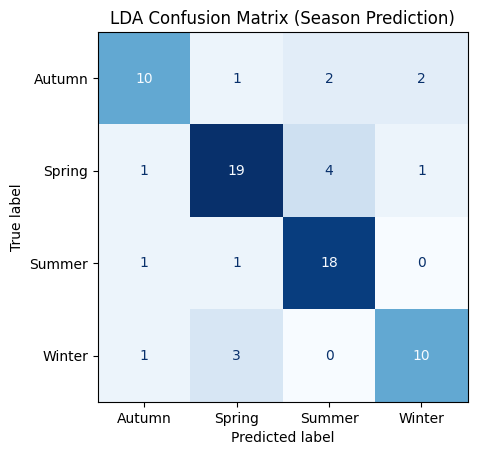

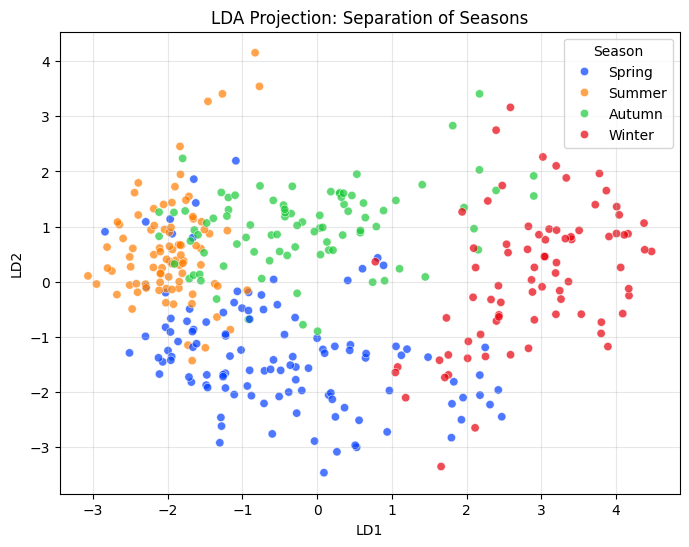

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# 1. Fit LDA
X_lda = df[['AvgTemperature', 'Humidity', 'Wind', 'Pressure']]
y_lda = df['Season']
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_lda, test_size=0.2, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(f"LDA Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")

# --- VISUALIZATION 1: Confusion Matrix ---
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, cmap='Blues', colorbar=False)
plt.title('LDA Confusion Matrix (Season Prediction)')
plt.show()

# --- VISUALIZATION 2: 2D Projection ---
# Transform all data to 2 dimensions for plotting
X_lda_2d = lda.transform(X_lda) 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda_2d[:, 0], y=X_lda_2d[:, 1], hue=y_lda, palette='bright', alpha=0.7)
plt.title('LDA Projection: Separation of Seasons')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Season')
plt.grid(True, alpha=0.3)
plt.show()

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'AvgTemperature': 'O', 'Humidity': 'O', 'Wind': 'O', 'Solar_PV': 'O'}


Predicting... (running safely in single-process mode)


100%|██████████| 23/23 [00:00<00:00, 315.35it/s]


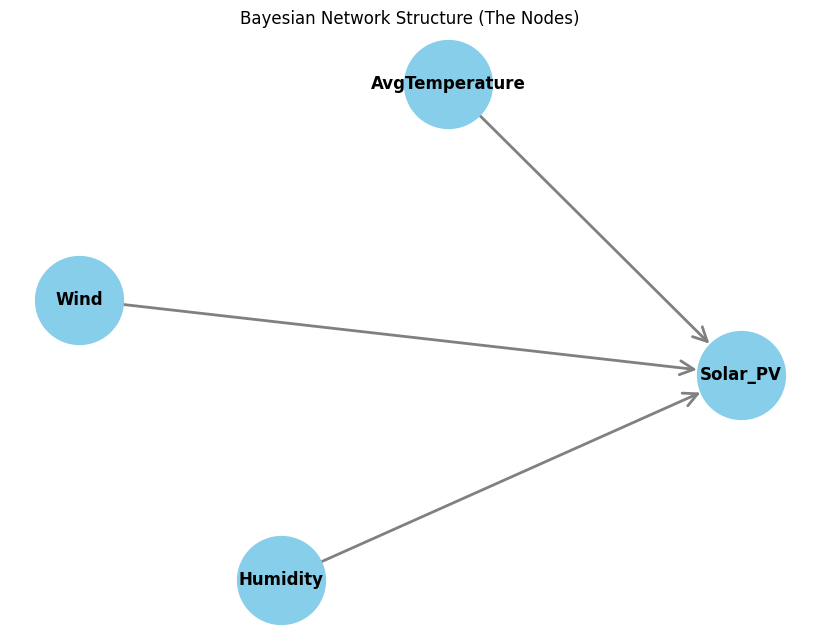

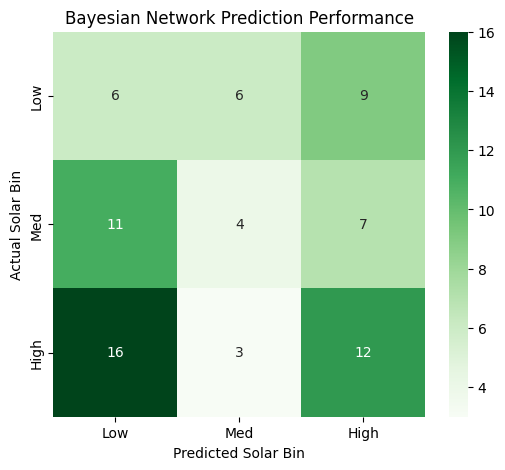

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import MaximumLikelihoodEstimator

# 1. Prepare Data
df_bn = df[['AvgTemperature', 'Humidity', 'Wind', 'Solar_PV']].copy()
for col in df_bn.columns:
    df_bn[col] = pd.qcut(df_bn[col], q=3, labels=['Low', 'Medium', 'High'])

# 2. Split
train_data, test_data = train_test_split(df_bn, test_size=0.2, random_state=42)

# 3. Fit
model = DiscreteBayesianNetwork([
    ('AvgTemperature', 'Solar_PV'),
    ('Humidity', 'Solar_PV'),
    ('Wind', 'Solar_PV')
])
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# 4. Predict (Safe Mode: n_jobs=1)
X_test = test_data.drop(columns=['Solar_PV'])
y_true = test_data['Solar_PV']

print("Predicting... (running safely in single-process mode)")
y_pred = model.predict(X_test, n_jobs=1)



# --- VISUALIZATION 1: The Network Nodes (Structure) ---
plt.figure(figsize=(8, 6))
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.spring_layout(G, seed=42) # Seed fixes the layout so it doesn't jump around

nx.draw(G, pos, 
        with_labels=True, 
        node_color='skyblue', 
        node_size=4000, 
        edge_color='gray', 
        width=2, 
        font_size=12, 
        font_weight='bold', 
        arrowsize=25,
        arrowstyle='->')
plt.title('Bayesian Network Structure (The Nodes)')
plt.show()

# --- VISUALIZATION 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred['Solar_PV'], labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Low', 'Med', 'High'], 
            yticklabels=['Low', 'Med', 'High'])
plt.xlabel('Predicted Solar Bin')
plt.ylabel('Actual Solar Bin')
plt.title('Bayesian Network Prediction Performance')
plt.show()

--- PCA Results ---
Explained Variance (PC1): 61.23%
Explained Variance (PC2): 25.32%
Total Variance Retained: 86.55%

--- Component Loadings ---
                     PC1       PC2
AvgTemperature  0.602862  0.074962
Humidity       -0.552119  0.159188
Wind            0.085162  0.981775
Pressure       -0.569623  0.071821


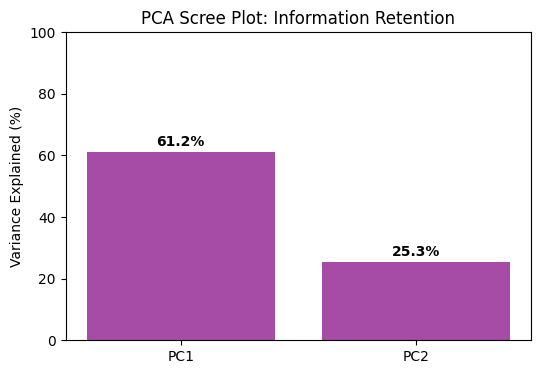

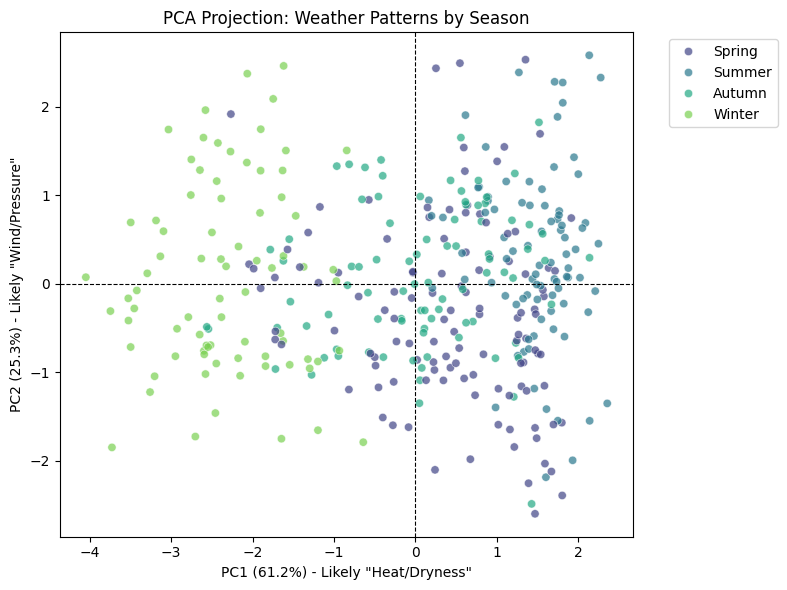

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Select & Scale Features
# We use the base numeric weather features
features_pca = ['AvgTemperature', 'Humidity', 'Wind', 'Pressure']
X_pca = df[features_pca].copy()

# PCA requires scaling (Mean=0, Variance=1)
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# 2. Apply PCA
# We keep 2 components for 2D visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_pca_scaled)

# Add results back to DataFrame for plotting
df['PCA_1'] = components[:, 0]
df['PCA_2'] = components[:, 1]

# 3. Print Explained Variance
var_ratio = pca.explained_variance_ratio_
print("--- PCA Results ---")
print(f"Explained Variance (PC1): {var_ratio[0]*100:.2f}%")
print(f"Explained Variance (PC2): {var_ratio[1]*100:.2f}%")
print(f"Total Variance Retained: {sum(var_ratio)*100:.2f}%")

# 4. Interpret Loadings (What makes up PC1/PC2?)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=features_pca
)
print("\n--- Component Loadings ---")
print(loadings)

# --- VISUALIZATION 1: Scree Plot (Variance Explained) ---
plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2'], var_ratio * 100, color='purple', alpha=0.7)
plt.ylabel('Variance Explained (%)')
plt.title('PCA Scree Plot: Information Retention')
plt.ylim(0, 100)
for i, v in enumerate(var_ratio):
    plt.text(i, v*100 + 2, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.show()

# --- VISUALIZATION 2: PCA Biplot with Season coloring ---
# (Assumes 'Season' column exists from previous step)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Season', data=df, palette='viridis', alpha=0.7)
plt.title('PCA Projection: Weather Patterns by Season')
plt.xlabel(f'PC1 ({var_ratio[0]*100:.1f}%) - Likely "Heat/Dryness"')
plt.ylabel(f'PC2 ({var_ratio[1]*100:.1f}%) - Likely "Wind/Pressure"')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

------------------------------
Decision Tree Accuracy: 0.7973 (79.73%)
------------------------------


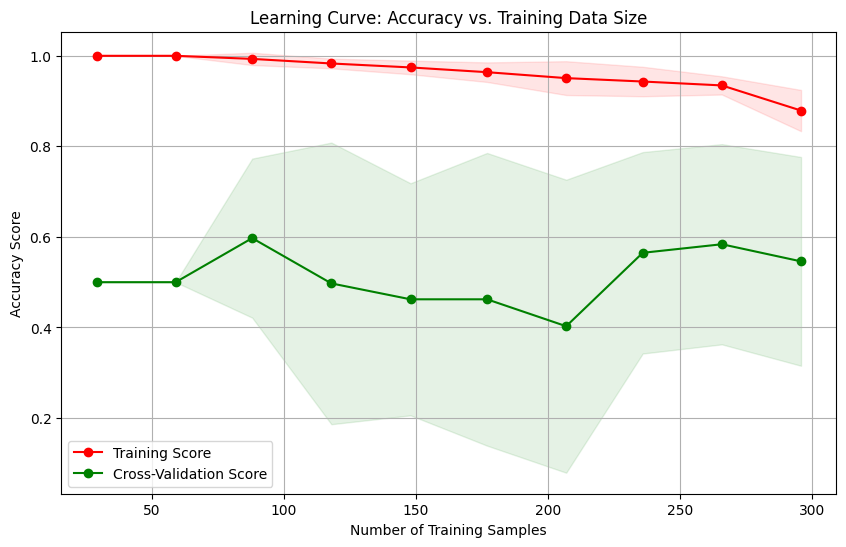

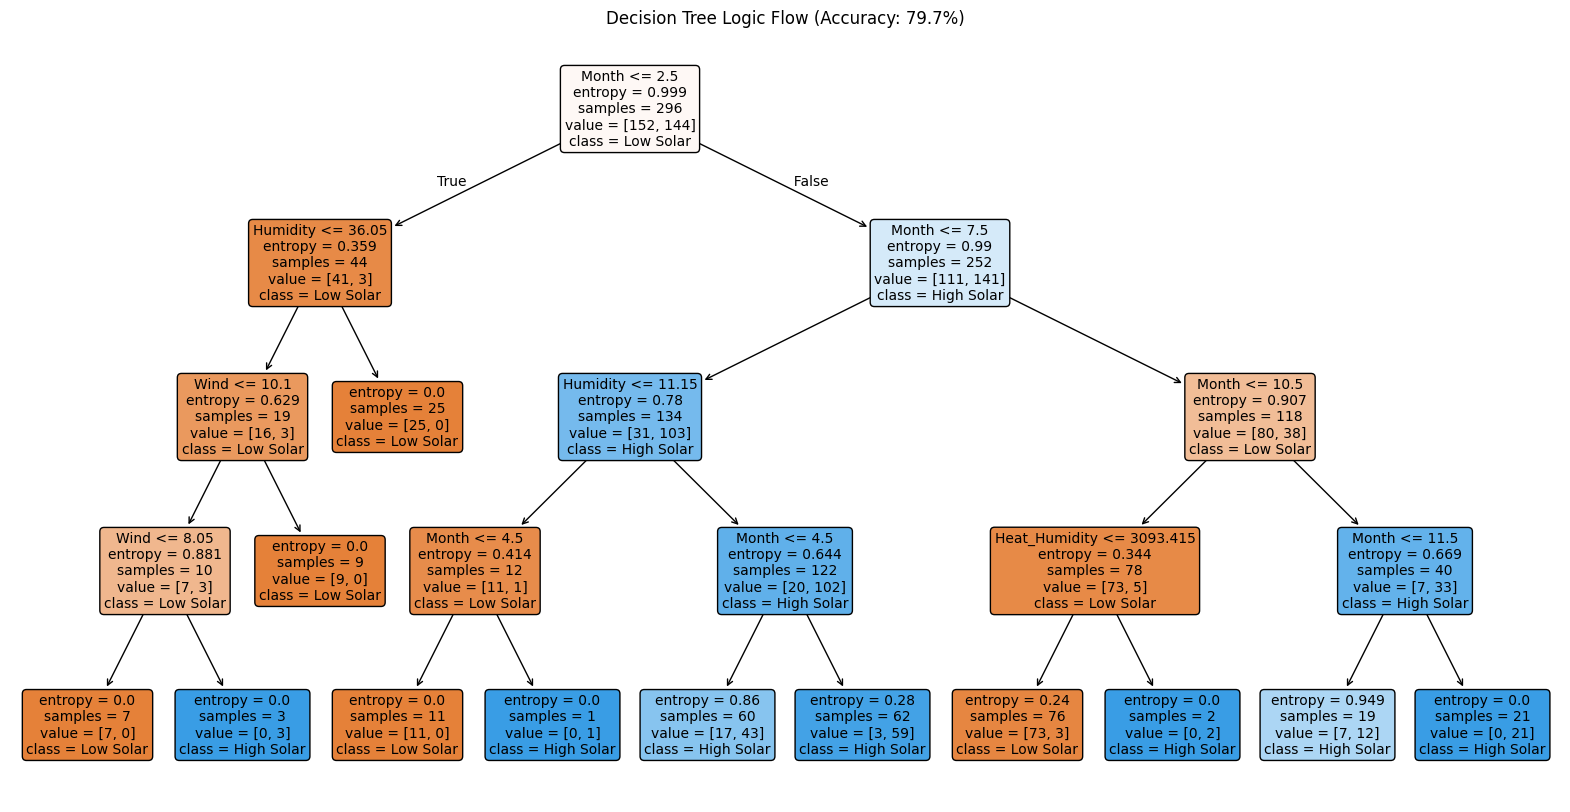

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score

# --- STEP 1: Feature Engineering ---
# 1. Seasonality Feature
df['Month'] = df['Date'].dt.month
# 2. Interaction Feature (Heat Stress)
df['Heat_Humidity'] = df['AvgTemperature'] * df['Humidity']
# 3. Pressure Anomaly
df['Pressure_Anomaly'] = df['Pressure'] - df['Pressure'].mean()

# Define Target (High vs Low Solar)
median_solar = df['Solar_PV'].median()
df['solar_class'] = (df['Solar_PV'] > median_solar).astype(int)

features = ['AvgTemperature', 'Humidity', 'Wind', 'Pressure', 'Month', 'Heat_Humidity']
X = df[features]
y = df['solar_class']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- STEP 2: Train Model ---
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt_entropy.fit(X_train, y_train)

# --- STEP 3: Calculate & Print Accuracy (ADDED) ---
y_pred = dt_entropy.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"Decision Tree Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("-" * 30)

# --- STEP 4: VISUALIZATION 1 - The Learning Curve ---
train_sizes, train_scores, test_scores = learning_curve(
    dt_entropy, X, y, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.title("Learning Curve: Accuracy vs. Training Data Size")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# --- STEP 5: VISUALIZATION 2 - The Decision Tree ---
plt.figure(figsize=(20, 10))
plot_tree(dt_entropy, 
          feature_names=features, 
          class_names=['Low Solar', 'High Solar'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title(f'Decision Tree Logic Flow (Accuracy: {accuracy*100:.1f}%)')
plt.show()

--- Regression Tree Performance Metrics ---
Mean Absolute Error (MAE):       5.3430 kWh
Root Mean Squared Error (RMSE):  7.1661 kWh
Correlation Coefficient (R²):    -0.0278
----------------------------------------
Willmott’s Index (d):            0.6569  (0 to 1)
Nash–Sutcliffe Efficiency (NSE): -0.0278  (-inf to 1)
Legates–McCabe Index (E1):       0.1562 (-inf to 1)


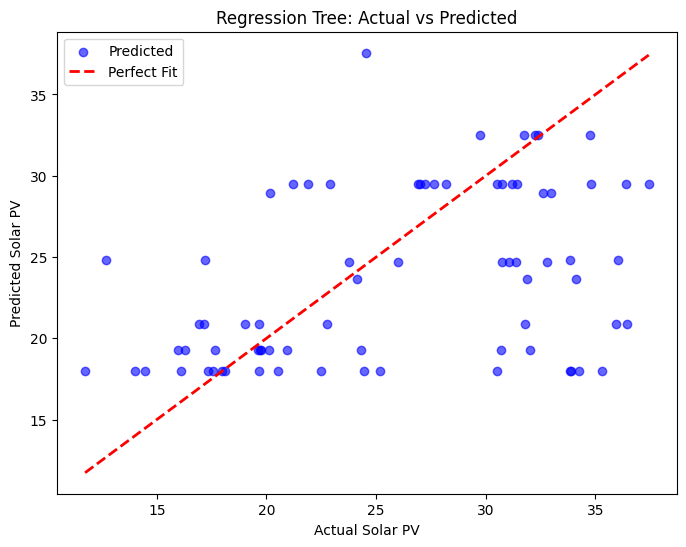

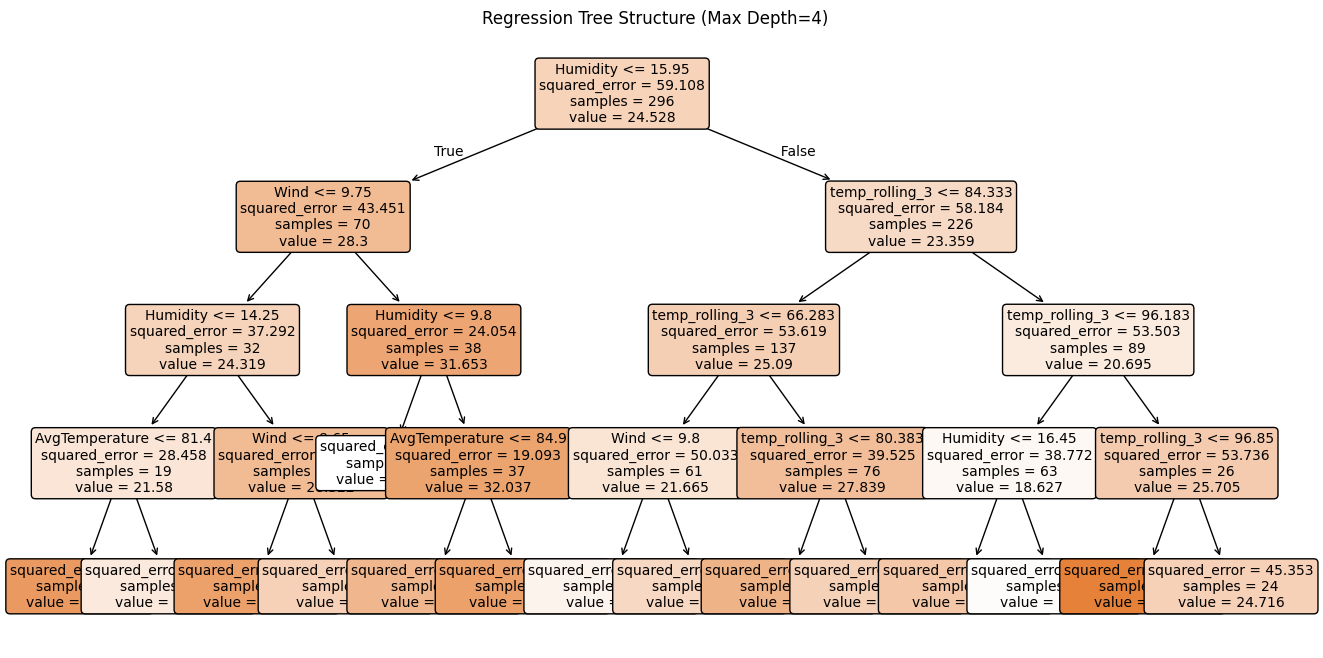

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Custom Metric Functions ---

def willmott_index(y_true, y_pred):
    """Willmott's Index of Agreement (d). Range: 0 to 1 (1 is perfect)."""
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    return 1 - (numerator / denominator)

def nash_sutcliffe_efficiency(y_true, y_pred):
    """Nash–Sutcliffe Efficiency (NSE). Range: -inf to 1 (1 is perfect)."""
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator)

def legates_mccabe_index(y_true, y_pred):
    """Legates-McCabe Efficiency Index (E1). Range: -inf to 1 (1 is perfect).
    Based on absolute errors (more robust to outliers than NSE)."""
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    return 1 - (numerator / denominator)

# --- 2. Data Preparation ---
# Using base features + rolling mean for regression
features = ['AvgTemperature', 'Humidity', 'Wind', 'Pressure', 'temp_rolling_3']
X = df[features].copy()
y = df['Solar_PV']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Train Regression Tree ---
# max_depth=4 keeps the tree readable and prevents overfitting on small data
reg_tree = DecisionTreeRegressor(max_depth=4, random_state=42)
reg_tree.fit(X_train, y_train)

# Predict
y_pred = reg_tree.predict(X_test)

# --- 4. Calculate All Metrics ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
d_index = willmott_index(y_test, y_pred)
nse = nash_sutcliffe_efficiency(y_test, y_pred)
lm_index = legates_mccabe_index(y_test, y_pred)

# --- 5. Print Results ---
print("--- Regression Tree Performance Metrics ---")
print(f"Mean Absolute Error (MAE):       {mae:.4f} kWh")
print(f"Root Mean Squared Error (RMSE):  {rmse:.4f} kWh")
print(f"Correlation Coefficient (R²):    {r2:.4f}")
print("-" * 40)
print(f"Willmott’s Index (d):            {d_index:.4f}  (0 to 1)")
print(f"Nash–Sutcliffe Efficiency (NSE): {nse:.4f}  (-inf to 1)")
print(f"Legates–McCabe Index (E1):       {lm_index:.4f} (-inf to 1)")

# --- 6. Visualization ---

# Plot A: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Solar PV')
plt.ylabel('Predicted Solar PV')
plt.title('Regression Tree: Actual vs Predicted')
plt.legend()
plt.show()

# Plot B: The Tree Structure
plt.figure(figsize=(16, 8))
plot_tree(reg_tree, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title('Regression Tree Structure (Max Depth=4)')
plt.show()

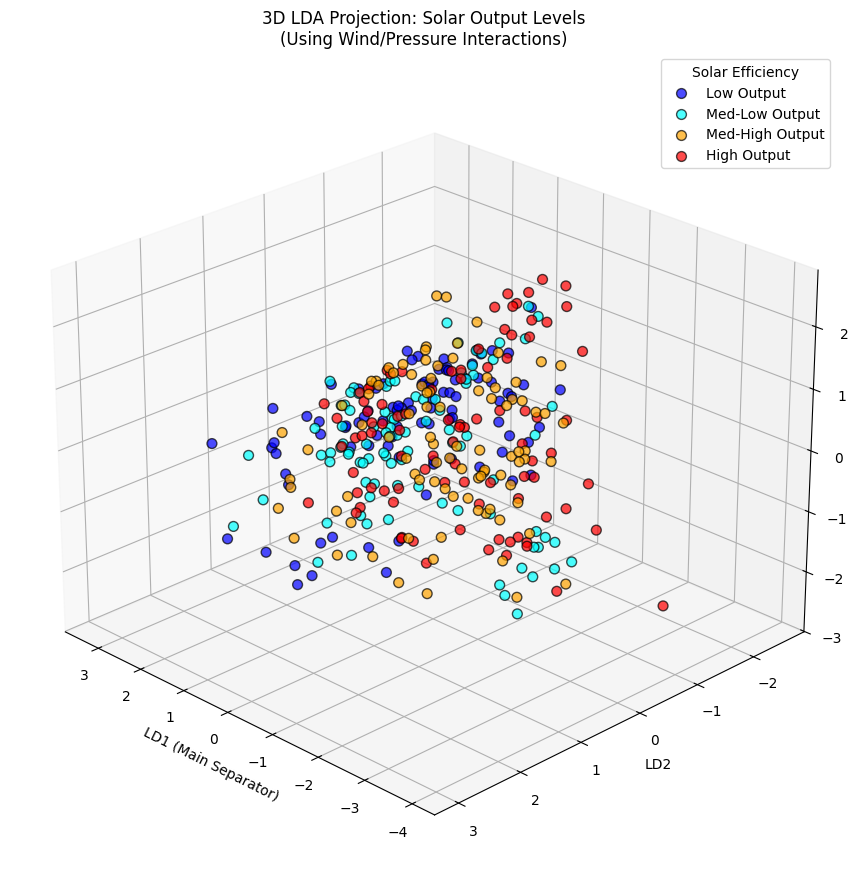

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

# 1. Prepare Data: Create 4 Classes for 3D Plotting
# We split Solar_PV into 4 equal buckets (Quartiles)
# Class 0: Lowest 25% | Class 3: Highest 25%
df['solar_quartile'] = pd.qcut(df['Solar_PV'], q=4, labels=['Low', 'Med-Low', 'Med-High', 'High'])

# Use your UPDATED feature list
features = [
    'AvgTemperature', 
    'Humidity', 
    'Wind', 
    'Pressure', 
    'temp_wind_pressure', 
    'temp_wind_pressure_z'
]

X = df[features]
y = df['solar_quartile']

# Encode labels (Low -> 0, Med-Low -> 1, etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Fit LDA with 3 Components
# We can now ask for 3 components because we have 4 classes
lda_3d = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda_3d.fit_transform(X, y)

# 3. Create the 3D Visualization
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Define colors for the 4 levels (Cool to Warm)
colors = ['blue', 'cyan', 'orange', 'red']
labels = ['Low Output', 'Med-Low Output', 'Med-High Output', 'High Output']

for i in range(4):
    mask = (y_encoded == i)
    ax.scatter(
        X_lda[mask, 0], # LD1
        X_lda[mask, 1], # LD2
        X_lda[mask, 2], # LD3
        c=colors[i],
        label=labels[i],
        s=50,           # Dot size
        alpha=0.7,      # Transparency
        edgecolor='k'   # Black border for clarity
    )

# 4. Labels and View
ax.set_xlabel('LD1 (Main Separator)')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')
ax.set_title('3D LDA Projection: Solar Output Levels\n(Using Wind/Pressure Interactions)')
ax.legend(title="Solar Efficiency")

# Adjust view angle for best perspective
ax.view_init(elev=25, azim=135)

plt.tight_layout()
plt.show()

Optimal K found: 5
--- KNN Performance (k=5) ---
1. Accuracy:       0.6351 (63.5%)
2. Error Rate:     0.3649 (36.5%)
3. Precision:      0.6944
4. Recall:         0.6098
5. F-measure (F1): 0.6494
6. ROC Area (AUC): 0.6330
------------------------------
Confusion Matrix:
[[22 11]
 [16 25]]


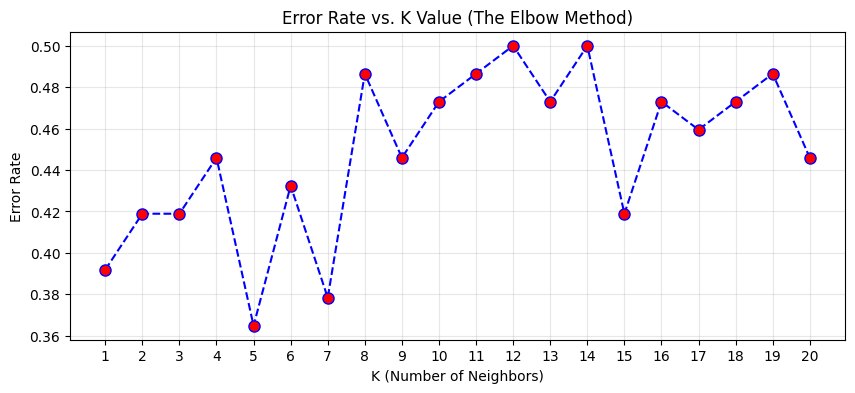

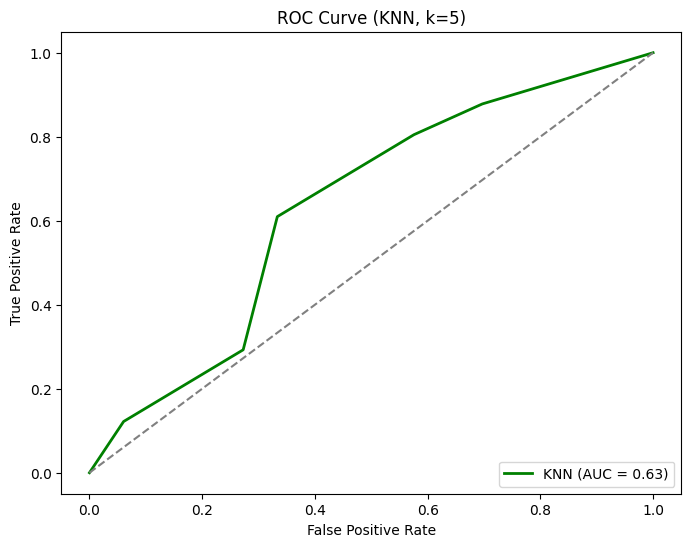

<Figure size 600x500 with 0 Axes>

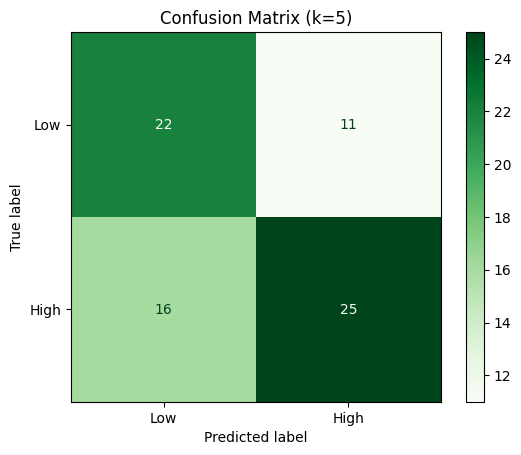

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_curve, auc, 
                             ConfusionMatrixDisplay)

# --- 1. Prepare Data & Features ---
# Target: 1 if Solar is "High", 0 if "Low"
median_solar = df['Solar_PV'].median()
df['is_high_solar'] = (df['Solar_PV'] > median_solar).astype(int)

# Use your advanced feature list
# Create interaction features if they don't already exist
if 'temp_wind_pressure' not in df.columns:
    df['temp_wind_pressure'] = df['AvgTemperature'] * df['Wind'] * df['Pressure']

if 'temp_wind_pressure_z' not in df.columns:
    t = df['temp_wind_pressure']
    # z-score with safe fallback to avoid division by zero
    denom = t.std(ddof=0)
    if denom == 0 or np.isnan(denom):
        df['temp_wind_pressure_z'] = 0.0
    else:
        df['temp_wind_pressure_z'] = (t - t.mean()) / denom

features = [
    'AvgTemperature',
    'Humidity',
    'Wind',
    'Pressure',
    'temp_wind_pressure',
    'temp_wind_pressure_z'
]

X = df[features]
y = df['is_high_solar']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Scaling (CRITICAL FOR KNN) ---
# We must scale features so they have Mean=0 and Std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. Find the Best 'K' (Elbow Method) ---
error_rates = []
k_range = range(1, 21) # Test K from 1 to 20

for k in k_range:
    knn_i = KNeighborsClassifier(n_neighbors=k)
    knn_i.fit(X_train_scaled, y_train)
    pred_i = knn_i.predict(X_test_scaled)
    error_rates.append(np.mean(pred_i != y_test))

# Pick the K with the lowest error
best_k = k_range[np.argmin(error_rates)]
print(f"Optimal K found: {best_k}")

# --- 4. Train Final Model with Best K ---
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

# --- 5. Calculate All Metrics ---
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# --- 6. Print Detailed Report ---
print(f"--- KNN Performance (k={best_k}) ---")
print(f"1. Accuracy:       {accuracy:.4f} ({(accuracy*100):.1f}%)")
print(f"2. Error Rate:     {error_rate:.4f} ({(error_rate*100):.1f}%)")
print(f"3. Precision:      {precision:.4f}")
print(f"4. Recall:         {recall:.4f}")
print(f"5. F-measure (F1): {f_measure:.4f}")
print(f"6. ROC Area (AUC): {roc_auc:.4f}")
print("-" * 30)
print(f"Confusion Matrix:\n{cm}")

# --- 7. Visualizations ---

# Visual A: The Elbow Plot (How we found K)
plt.figure(figsize=(10, 4))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o', 
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value (The Elbow Method)')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.xticks(k_range)
plt.grid(alpha=0.3)
plt.show()

# Visual B: ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'ROC Curve (KNN, k={best_k})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Visual C: Confusion Matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', display_labels=['Low', 'High'])
plt.title(f'Confusion Matrix (k={best_k})')
plt.show()